In [ ]:
%pip install catboost matplotlib seaborn scikit-learn pandas

In [1]:
import catboost
import sklearn
import matplotlib
import seaborn
import pandas

print("All libraries imported successfully")

All libraries imported successfully


In [2]:
# ================================
# Part 3 Regression - Setup Cell
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Plot settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)

print("Part 3 Regression environment fully initialized")


Part 3 Regression environment fully initialized


In [3]:
# ================================
# Cell 4: Load California Housing Dataset
# ================================

import os

# csv_path = os.path.join(path, "housing.csv")
csv_path = "housing.csv"
print("Loading data from:", csv_path)

df = pd.read_csv(csv_path)

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

df.head()


Loading data from: housing.csv
Dataset shape: (20640, 10)
Columns: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# ================================
# Cell 5: Train / Validation / Test Split
# ================================

TARGET_COLUMN = "median_house_value"

X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

# 60% train, 20% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_SEED
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_SEED
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)


Train size: (12384, 9)
Validation size: (4128, 9)
Test size: (4128, 9)


In [ ]:
%pip install kagglehub

In [5]:
import kagglehub

path = kagglehub.dataset_download("camnugent/california-housing-prices")
print("Path to dataset files:", path)


c:\Users\alexk\OneDrive\Documents\CSE 176\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\alexk\.cache\kagglehub\datasets\camnugent\california-housing-prices\versions\1


In [6]:
import os
os.listdir(path)


['housing.csv']

In [7]:
# ================================
# Cell 6: One-Hot Encode Categorical Feature for Baselines
# ================================

X_train_enc = pd.get_dummies(X_train, drop_first=True)
X_val_enc = pd.get_dummies(X_val, drop_first=True)
X_test_enc = pd.get_dummies(X_test, drop_first=True)

# Align columns across splits
X_train_enc, X_val_enc = X_train_enc.align(X_val_enc, join="left", axis=1, fill_value=0)
X_train_enc, X_test_enc = X_train_enc.align(X_test_enc, join="left", axis=1, fill_value=0)

print("Encoded feature dimension:", X_train_enc.shape[1])


Encoded feature dimension: 12


In [31]:
# ================================
# Cell 7: Baseline 1 — Mean Predictor (Enhanced)
# ================================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
import numpy as np
import time

start_time = time.time()   # ---- Start timing ----

# ---- Direct train/val/test evaluation ----
mean_value = y_train.mean()

y_val_pred_mean = np.full_like(y_val, fill_value=mean_value, dtype=np.float64)
y_test_pred_mean = np.full_like(y_test, fill_value=mean_value, dtype=np.float64)

rmse_val_mean = np.sqrt(mean_squared_error(y_val, y_val_pred_mean))
rmse_test_mean = np.sqrt(mean_squared_error(y_test, y_test_pred_mean))

mae_val_mean = mean_absolute_error(y_val, y_val_pred_mean)
mae_test_mean = mean_absolute_error(y_test, y_test_pred_mean)

r2_val_mean = r2_score(y_val, y_val_pred_mean)
r2_test_mean = r2_score(y_test, y_test_pred_mean)

mape_val_mean = np.mean(np.abs((y_val - y_val_pred_mean) / y_val)) * 100
mape_test_mean = np.mean(np.abs((y_test - y_test_pred_mean) / y_test)) * 100

print("=== Mean Baseline — Train/Val/Test Metrics ===")
print("Validation RMSE:", rmse_val_mean)
print("Test RMSE:", rmse_test_mean)
print("Validation MAE:", mae_val_mean)
print("Test MAE:", mae_test_mean)
print("Validation R²:", r2_val_mean)
print("Test R²:", r2_test_mean)
print("Validation MAPE (%):", mape_val_mean)
print("Test MAPE (%):", mape_test_mean)

# ---- K-Fold Cross Validation for the baseline ----
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores_mean = []
mae_scores_mean = []
r2_scores_mean = []

for train_idx, val_idx in kf.split(X_train):
    y_tr = y_train.iloc[train_idx]
    y_va = y_train.iloc[val_idx]
    
    mean_fold = y_tr.mean()
    y_va_pred = np.full_like(y_va, fill_value=mean_fold, dtype=np.float64)

    rmse_scores_mean.append(np.sqrt(mean_squared_error(y_va, y_va_pred)))
    mae_scores_mean.append(mean_absolute_error(y_va, y_va_pred))
    r2_scores_mean.append(r2_score(y_va, y_va_pred))

end_time = time.time()     # ---- End timing ----
training_time_mean = end_time - start_time

print("\n=== Mean Baseline — 5-Fold Cross-Validation ===")
print("CV RMSE:", np.mean(rmse_scores_mean))
print("CV MAE:", np.mean(mae_scores_mean))
print("CV R²:", np.mean(r2_scores_mean))


=== Mean Baseline — Train/Val/Test Metrics ===
Validation RMSE: 117190.26146707441
Test RMSE: 114480.56237506813
Validation MAE: 92479.30605116252
Test MAE: 90529.56864008072
Validation R²: -0.0001744722947540911
Test R²: -0.00013044624474112254
Validation MAPE (%): 61.75383241869133
Test MAPE (%): 62.73140373371526

=== Mean Baseline — 5-Fold Cross-Validation ===
CV RMSE: 115092.93673907027
CV MAE: 90940.7334893664
CV R²: -0.0004494972427287802


In [10]:
# ================================
# Cell 8a: Impute Missing Values for Linear Regression
# ================================

from sklearn.impute import SimpleImputer

# Use median imputation so we do not shift the distribution too much
imputer = SimpleImputer(strategy="median")

X_train_lr = imputer.fit_transform(X_train_enc)
X_val_lr = imputer.transform(X_val_enc)
X_test_lr = imputer.transform(X_test_enc)

print("After imputation:")
print("Train shape:", X_train_lr.shape)
print("Validation shape:", X_val_lr.shape)
print("Test shape:", X_test_lr.shape)



After imputation:
Train shape: (12384, 12)
Validation shape: (4128, 12)
Test shape: (4128, 12)


In [32]:
# ================================
# Cell 8: Baseline 2 — Linear Regression (with imputation)
# ================================
import time
from sklearn.model_selection import KFold, cross_val_score

# -------------------------
# Training time measurement
# -------------------------
start_time = time.time()

linreg = LinearRegression()
linreg.fit(X_train_lr, y_train)

y_val_pred_lr = linreg.predict(X_val_lr)
y_test_pred_lr = linreg.predict(X_test_lr)

end_time = time.time()
training_time_lr = end_time - start_time

# -------------------------
# Metrics
# -------------------------
rmse_val_lr = np.sqrt(mean_squared_error(y_val, y_val_pred_lr))
rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))

mae_val_lr = mean_absolute_error(y_val, y_val_pred_lr)
mae_test_lr = mean_absolute_error(y_test, y_test_pred_lr)

r2_val_lr = r2_score(y_val, y_val_pred_lr)
r2_test_lr = r2_score(y_test, y_test_pred_lr)

# -------------------------
# K-Fold Cross-Validation (5-fold)
# -------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores_lr = -cross_val_score(
    linreg,
    X_train_lr,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=kf
)

mae_scores_lr = -cross_val_score(
    linreg,
    X_train_lr,
    y_train,
    scoring="neg_mean_absolute_error",
    cv=kf
)

r2_scores_lr = cross_val_score(
    linreg,
    X_train_lr,
    y_train,
    scoring="r2",
    cv=kf
)

# -------------------------
# Output
# -------------------------
print("Linear Regression Validation RMSE:", rmse_val_lr)
print("Linear Regression Test RMSE:", rmse_test_lr)
print("Linear Regression Validation MAE:", mae_val_lr)
print("Linear Regression Test MAE:", mae_test_lr)
print("Linear Regression Validation R²:", r2_val_lr)
print("Linear Regression Test R²:", r2_test_lr)
print(f"Linear Regression Training Time: {training_time_lr:.6f} seconds\n")

print("----- 5-Fold Cross-Validation Results -----")
print(f"CV RMSE: Mean = {rmse_scores_lr.mean():.4f}, Std = {rmse_scores_lr.std():.4f}")
print(f"CV MAE:  Mean = {mae_scores_lr.mean():.4f}, Std = {mae_scores_lr.std():.4f}")
print(f"CV R²:   Mean = {r2_scores_lr.mean():.4f}, Std = {r2_scores_lr.std():.4f}")



Linear Regression Validation RMSE: 68645.27789950231
Linear Regression Test RMSE: 70084.56658068163
Linear Regression Validation MAE: 50101.78545243698
Linear Regression Test MAE: 50720.18747205691
Linear Regression Validation R²: 0.6568262548149681
Linear Regression Test R²: 0.6251669093876565
Linear Regression Training Time: 0.018624 seconds

----- 5-Fold Cross-Validation Results -----
CV RMSE: Mean = 68621.3191, Std = 1443.5729
CV MAE:  Mean = 49610.9301, Std = 678.6428
CV R²:   Mean = 0.6441, Std = 0.0158


In [35]:
# ================================
# Cell 9: CatBoost Baseline Model (Fixed for cross_val_score)
# ================================
import time
from sklearn.model_selection import KFold, cross_val_score
from catboost import CatBoostRegressor, Pool
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------
# Identify categorical columns
# -------------------------
feature_names = X_train.columns.tolist()
cat_features = [feature_names.index("ocean_proximity")]
print("Categorical feature indices:", cat_features)

# Build CatBoost Pools
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# -------------------------
# CatBoost parameters
# -------------------------
cat_params = {
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "iterations": 500,
    "learning_rate": 0.1,
    "depth": 6,
    "l2_leaf_reg": 3.0,
    "random_seed": RANDOM_SEED,
    "bootstrap_type": "Bayesian",
    "bagging_temperature": 1.0,
    "od_type": "Iter",
    "od_wait": 50,
    "verbose": 50
}

# -------------------------
# Training time measurement
# -------------------------
start_time = time.time()

# Use sklearn-compatible estimator for training
cat_model = CatBoostRegressor(**cat_params)
cat_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_val, y_val),
    use_best_model=True
)

end_time = time.time()
training_time_cat = end_time - start_time

# -------------------------
# Predictions
# -------------------------
y_val_pred_cat = cat_model.predict(X_val)
y_test_pred_cat = cat_model.predict(X_test)

# -------------------------
# Metrics
# -------------------------
rmse_val_cat = np.sqrt(mean_squared_error(y_val, y_val_pred_cat))
rmse_test_cat = np.sqrt(mean_squared_error(y_test, y_test_pred_cat))

mae_val_cat = mean_absolute_error(y_val, y_val_pred_cat)
mae_test_cat = mean_absolute_error(y_test, y_test_pred_cat)

r2_val_cat = r2_score(y_val, y_val_pred_cat)
r2_test_cat = r2_score(y_test, y_test_pred_cat)

# -------------------------
# 5-Fold Cross-Validation
# -------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores_cat = []
mae_scores_cat = []
r2_scores_cat = []

for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = CatBoostRegressor(**cat_params)
    model.fit(X_tr, y_tr, cat_features=cat_features, verbose=False)

    y_pred = model.predict(X_val_fold)

    rmse_scores_cat.append(np.sqrt(mean_squared_error(y_val_fold, y_pred)))
    mae_scores_cat.append(mean_absolute_error(y_val_fold, y_pred))
    r2_scores_cat.append(r2_score(y_val_fold, y_pred))

print("----- 5-Fold Cross-Validation Results -----")
print(f"CV RMSE: Mean = {np.mean(rmse_scores_cat):.2f}, Std = {np.std(rmse_scores_cat):.2f}")
print(f"CV MAE:  Mean = {np.mean(mae_scores_cat):.2f}, Std = {np.std(mae_scores_cat):.2f}")
print(f"CV R²:   Mean = {np.mean(r2_scores_cat):.4f}, Std = {np.std(r2_scores_cat):.4f}")
# -------------------------
# Output
# -------------------------
print("CatBoost Validation RMSE:", rmse_val_cat)
print("CatBoost Test RMSE:", rmse_test_cat)
print("CatBoost Validation MAE:", mae_val_cat)
print("CatBoost Test MAE:", mae_test_cat)
print("CatBoost Validation R²:", r2_val_cat)
print("CatBoost Test R²:", r2_test_cat)
print(f"CatBoost Training Time: {training_time_cat:.2f} seconds\n")

print("----- 5-Fold Cross-Validation Results -----")
print(f"CV RMSE: Mean = {np.mean(rmse_scores_cat):.2f}, Std = {np.std(rmse_scores_cat):.2f}")
print(f"CV MAE:  Mean = {np.mean(mae_scores_cat):.2f}, Std = {np.std(mae_scores_cat):.2f}")
print(f"CV R²:   Mean = {np.mean(r2_scores_cat):.4f}, Std = {np.std(r2_scores_cat):.4f}")

# Save eval history for learning curves
evals_result = cat_model.get_evals_result()


Categorical feature indices: [8]
0:	learn: 108637.8268439	test: 110700.8170731	best: 110700.8170731 (0)	total: 76.9ms	remaining: 38.4s
50:	learn: 56259.3101951	test: 57636.2098269	best: 57636.2098269 (50)	total: 2.48s	remaining: 21.8s
100:	learn: 50974.2522006	test: 53454.6540260	best: 53454.6540260 (100)	total: 4.99s	remaining: 19.7s
150:	learn: 47826.8944413	test: 51293.9349709	best: 51293.9349709 (150)	total: 7.66s	remaining: 17.7s
200:	learn: 45640.9294821	test: 50110.1074734	best: 50110.1074734 (200)	total: 10.4s	remaining: 15.5s
250:	learn: 43923.8950755	test: 49260.2282704	best: 49260.2282704 (250)	total: 13s	remaining: 12.9s
300:	learn: 42502.9549148	test: 48599.4567806	best: 48599.4567806 (300)	total: 15.6s	remaining: 10.3s
350:	learn: 41405.3510242	test: 48272.7605882	best: 48272.7605882 (350)	total: 18.2s	remaining: 7.71s
400:	learn: 40406.4139439	test: 47944.2265652	best: 47944.2265652 (400)	total: 20.8s	remaining: 5.13s
450:	learn: 39448.9958875	test: 47751.0742480	best: 4

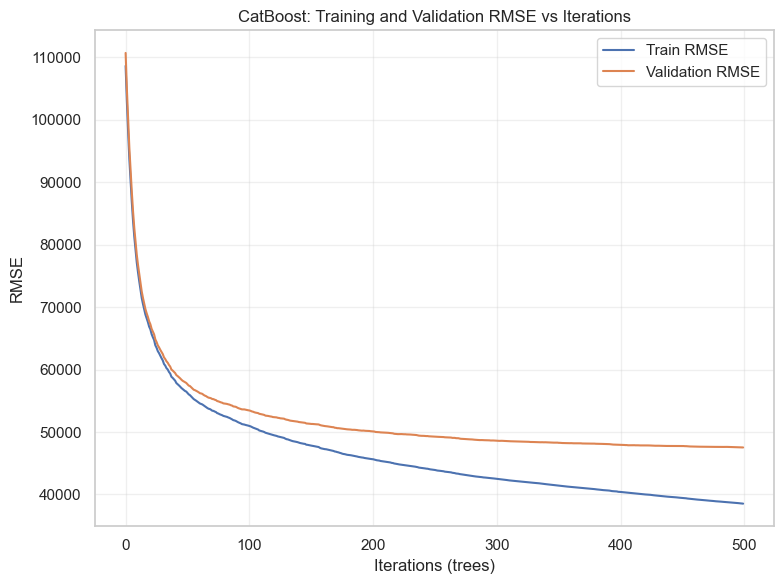

In [36]:
# ================================
# Cell 10: Learning Curves (RMSE)
# ================================

train_rmse = evals_result["learn"]["RMSE"]
val_rmse = evals_result["validation"]["RMSE"]

plt.figure()
plt.plot(train_rmse, label="Train RMSE")
plt.plot(val_rmse, label="Validation RMSE")
plt.xlabel("Iterations (trees)")
plt.ylabel("RMSE")
plt.title("CatBoost: Training and Validation RMSE vs Iterations")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Iterations=  50 | Val RMSE=57,650.70 | Test RMSE=58,929.33
Iterations= 100 | Val RMSE=53,185.49 | Test RMSE=54,225.72
Iterations= 200 | Val RMSE=50,114.93 | Test RMSE=51,001.25
Iterations= 300 | Val RMSE=48,616.82 | Test RMSE=49,488.12
Iterations= 400 | Val RMSE=47,952.15 | Test RMSE=48,604.81
Iterations= 500 | Val RMSE=47,531.58 | Test RMSE=47,988.57
Iterations= 700 | Val RMSE=47,050.05 | Test RMSE=47,271.65
Iterations=1000 | Val RMSE=46,695.55 | Test RMSE=46,913.17


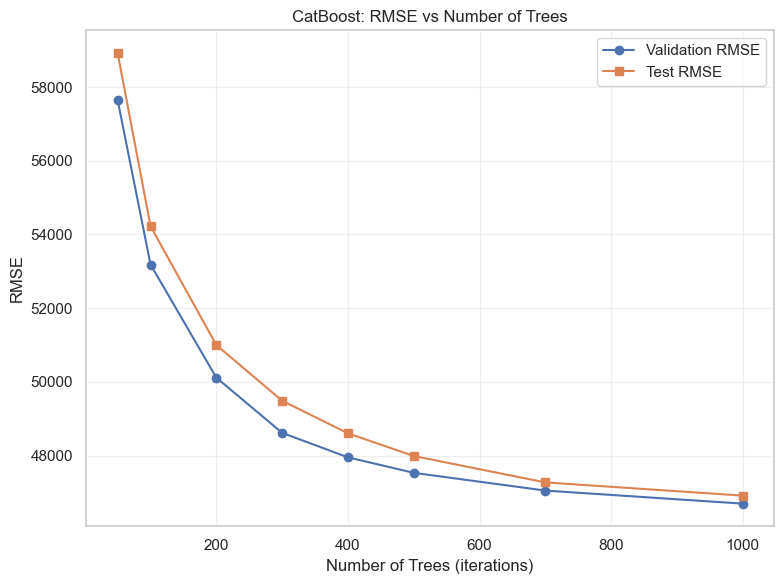

In [37]:
# ================================
# Cell 11: Test RMSE vs Number of Trees
# ================================

iter_values = [50, 100, 200, 300, 400, 500, 700, 1000]
test_rmse_list = []
val_rmse_list = []

for n_iter in iter_values:
    params_iter = cat_params.copy()
    params_iter["iterations"] = n_iter
    params_iter["verbose"] = False
    # Disable early stopping so we really use n_iter trees
    params_iter["od_type"] = "None"

    model_iter = CatBoostRegressor(**params_iter)
    model_iter.fit(train_pool, eval_set=val_pool, use_best_model=False, verbose=False)

    y_val_pred = model_iter.predict(val_pool)
    y_test_pred = model_iter.predict(test_pool)

    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    val_rmse_list.append(val_rmse)
    test_rmse_list.append(test_rmse)

    print(f"Iterations={n_iter:4d} | Val RMSE={val_rmse:,.2f} | Test RMSE={test_rmse:,.2f}")

plt.figure()
plt.plot(iter_values, val_rmse_list, marker="o", label="Validation RMSE")
plt.plot(iter_values, test_rmse_list, marker="s", label="Test RMSE")
plt.xlabel("Number of Trees (iterations)")
plt.ylabel("RMSE")
plt.title("CatBoost: RMSE vs Number of Trees")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Depth= 3 | Val RMSE=50,939.73 | Test RMSE=51,543.20
Depth= 4 | Val RMSE=49,606.12 | Test RMSE=50,029.66
Depth= 5 | Val RMSE=48,599.22 | Test RMSE=48,691.55
Depth= 6 | Val RMSE=47,531.58 | Test RMSE=47,988.57
Depth= 8 | Val RMSE=47,112.58 | Test RMSE=47,380.47
Depth=10 | Val RMSE=47,042.58 | Test RMSE=47,231.56


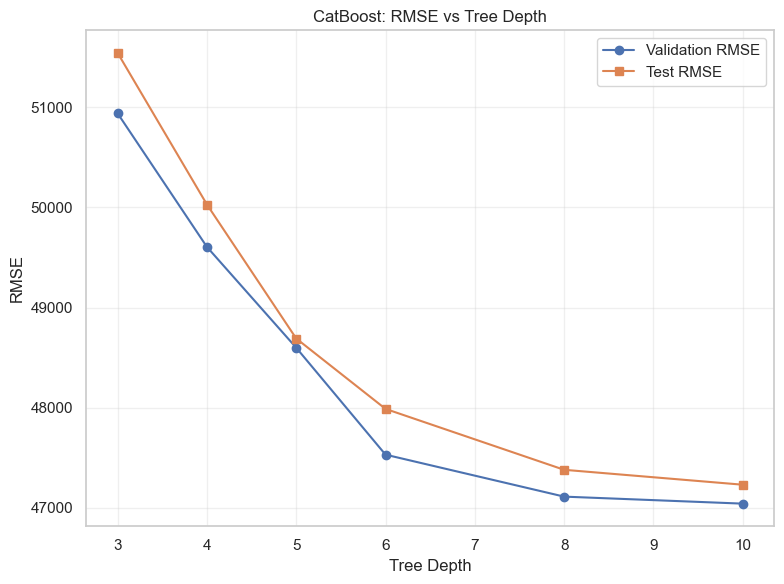

In [38]:
# ================================
# Cell 12: RMSE vs Tree Depth
# ================================

depth_values = [3, 4, 5, 6, 8, 10]
val_rmse_depth = []
test_rmse_depth = []

for d in depth_values:
    params_depth = cat_params.copy()
    params_depth["depth"] = d
    params_depth["iterations"] = 500
    params_depth["verbose"] = False
    params_depth["od_type"] = "None"

    model_depth = CatBoostRegressor(**params_depth)
    model_depth.fit(train_pool, eval_set=val_pool, use_best_model=False, verbose=False)

    y_val_pred = model_depth.predict(val_pool)
    y_test_pred = model_depth.predict(test_pool)

    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    val_rmse_depth.append(val_rmse)
    test_rmse_depth.append(test_rmse)

    print(f"Depth={d:2d} | Val RMSE={val_rmse:,.2f} | Test RMSE={test_rmse:,.2f}")

plt.figure()
plt.plot(depth_values, val_rmse_depth, marker="o", label="Validation RMSE")
plt.plot(depth_values, test_rmse_depth, marker="s", label="Test RMSE")
plt.xlabel("Tree Depth")
plt.ylabel("RMSE")
plt.title("CatBoost: RMSE vs Tree Depth")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Learning Rate=0.010 | Val RMSE=57,899.11 | Test RMSE=58,865.52
Learning Rate=0.030 | Val RMSE=51,021.50 | Test RMSE=51,807.42
Learning Rate=0.050 | Val RMSE=49,191.35 | Test RMSE=49,831.98
Learning Rate=0.100 | Val RMSE=47,531.58 | Test RMSE=47,988.57
Learning Rate=0.200 | Val RMSE=47,230.54 | Test RMSE=47,544.27


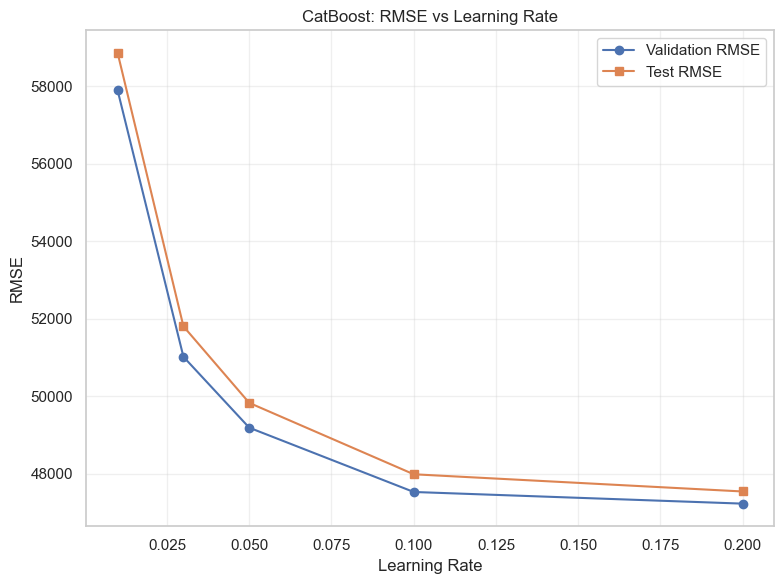

In [18]:
# ================================
# Cell 13: RMSE vs Learning Rate
# ================================

lr_values = [0.01, 0.03, 0.05, 0.1, 0.2]
val_rmse_lr = []
test_rmse_lr = []

for lr in lr_values:
    params_lr = cat_params.copy()
    params_lr["learning_rate"] = lr
    params_lr["iterations"] = 500
    params_lr["verbose"] = False
    params_lr["od_type"] = "None"

    model_lr = CatBoostRegressor(**params_lr)
    model_lr.fit(train_pool, eval_set=val_pool, use_best_model=False, verbose=False)

    y_val_pred = model_lr.predict(val_pool)
    y_test_pred = model_lr.predict(test_pool)

    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    val_rmse_lr.append(val_rmse)
    test_rmse_lr.append(test_rmse)

    print(f"Learning Rate={lr:.3f} | Val RMSE={val_rmse:,.2f} | Test RMSE={test_rmse:,.2f}")

plt.figure()
plt.plot(lr_values, val_rmse_lr, marker="o", label="Validation RMSE")
plt.plot(lr_values, test_rmse_lr, marker="s", label="Test RMSE")
plt.xlabel("Learning Rate")
plt.ylabel("RMSE")
plt.title("CatBoost: RMSE vs Learning Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [39]:
# ================================
# Cell 14: PCA Setup (Numeric Features)
# ================================

from sklearn.pipeline import Pipeline

# Separate numeric and categorical columns
numeric_features = X_train.select_dtypes(include=[np.number])
categorical_feature = X_train[["ocean_proximity"]]

# Standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(numeric_features)
X_val_scaled = scaler.transform(X_val[numeric_features.columns])
X_test_scaled = scaler.transform(X_test[numeric_features.columns])

print("Scaled numeric feature shape:", X_train_scaled.shape)


Scaled numeric feature shape: (12384, 8)


In [40]:
# ================================
# Cell 15 (Corrected): Impute + Apply PCA
# ================================

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Impute missing values BEFORE PCA (required)
pca_imputer = SimpleImputer(strategy="median")

X_train_scaled_imp = pca_imputer.fit_transform(X_train_scaled)
X_val_scaled_imp = pca_imputer.transform(X_val_scaled)
X_test_scaled_imp = pca_imputer.transform(X_test_scaled)

# Apply PCA (retain 95% variance)
pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train_scaled_imp)
X_val_pca = pca.transform(X_val_scaled_imp)
X_test_pca = pca.transform(X_test_scaled_imp)

print("Original numeric dimension:", X_train_scaled.shape[1])
print("Reduced PCA dimension:", X_train_pca.shape[1])


Original numeric dimension: 8
Reduced PCA dimension: 4


In [ ]:
# ================================
# Cell 16: CatBoost on PCA Features Only
# ================================
import time
from sklearn.model_selection import KFold, cross_val_score

# -------------------------
# CatBoost parameters
# -------------------------
pca_params = {
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "iterations": 700,
    "learning_rate": 0.2,
    "depth": 10,
    "random_seed": RANDOM_SEED,
    "verbose": 50
}

cat_pca = CatBoostRegressor(**pca_params)

# -------------------------
# Training time measurement
# -------------------------
start_time = time.time()

cat_pca.fit(
    X_train_pca, y_train,
    eval_set=(X_val_pca, y_val),
    use_best_model=True
)

end_time = time.time()
training_time_pca = end_time - start_time

# -------------------------
# Predictions
# -------------------------
y_val_pred_pca = cat_pca.predict(X_val_pca)
y_test_pred_pca = cat_pca.predict(X_test_pca)

# -------------------------
# Metrics
# -------------------------
rmse_val_pca = np.sqrt(mean_squared_error(y_val, y_val_pred_pca))
rmse_test_pca = np.sqrt(mean_squared_error(y_test, y_test_pred_pca))

mae_val_pca = mean_absolute_error(y_val, y_val_pred_pca)
mae_test_pca = mean_absolute_error(y_test, y_test_pred_pca)

r2_val_pca = r2_score(y_val, y_val_pred_pca)
r2_test_pca = r2_score(y_test, y_test_pred_pca)

# -------------------------
# 5-Fold Cross-Validation
# -------------------------
y_train_np = y_train.to_numpy()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores_pca = []
mae_scores_pca = []
r2_scores_pca = []

for train_idx, val_idx in kf.split(X_train_pca):
    X_tr, X_val_fold = X_train_pca[train_idx], X_train_pca[val_idx]
    y_tr, y_val_fold = y_train_np[train_idx], y_train_np[val_idx]

    model = CatBoostRegressor(**pca_params)
    model.fit(X_tr, y_tr, eval_set=(X_val_fold, y_val_fold), verbose=False)

    y_pred = model.predict(X_val_fold)

    rmse_scores_pca.append(np.sqrt(mean_squared_error(y_val_fold, y_pred)))
    mae_scores_pca.append(mean_absolute_error(y_val_fold, y_pred))
    r2_scores_pca.append(r2_score(y_val_fold, y_pred))

print("----- 5-Fold CV Results (PCA) -----")
print(f"CV RMSE: Mean = {np.mean(rmse_scores_pca):.2f}, Std = {np.std(rmse_scores_pca):.2f}")
print(f"CV MAE:  Mean = {np.mean(mae_scores_pca):.2f}, Std = {np.std(mae_scores_pca):.2f}")
print(f"CV R²:   Mean = {np.mean(r2_scores_pca):.4f}, Std = {np.std(r2_scores_pca):.4f}")



0:	learn: 103753.2150475	test: 105599.7707966	best: 105599.7707966 (0)	total: 31ms	remaining: 21.7s
50:	learn: 64544.4618515	test: 70160.0151648	best: 70160.0151648 (50)	total: 1.28s	remaining: 16.3s
100:	learn: 59248.6876507	test: 69130.1042774	best: 69130.1042774 (100)	total: 2.5s	remaining: 14.8s
150:	learn: 55279.5286975	test: 69084.5100315	best: 69068.5302396 (117)	total: 3.65s	remaining: 13.3s
200:	learn: 51989.5579480	test: 69104.1093644	best: 69029.1966866 (163)	total: 4.82s	remaining: 12s
250:	learn: 49169.8116599	test: 69210.4177796	best: 69029.1966866 (163)	total: 5.99s	remaining: 10.7s
300:	learn: 46647.8941868	test: 69235.1356146	best: 69029.1966866 (163)	total: 7.15s	remaining: 9.47s
350:	learn: 44463.0249135	test: 69289.5806849	best: 69029.1966866 (163)	total: 8.31s	remaining: 8.27s
400:	learn: 42237.5116930	test: 69459.7767731	best: 69029.1966866 (163)	total: 9.48s	remaining: 7.07s
450:	learn: 40337.9096662	test: 69612.2859378	best: 69029.1966866 (163)	total: 10.7s	rema

In [42]:
import pandas as pd
import numpy

# Example: compute mean ± std for each model's CV scores
def format_cv(scores):
    return f"{np.mean(scores):.2f} ± {np.std(scores):.2f}"


results = {
    "Model": [
        "Mean baseline",
        "Linear Regression (one-hot + impute)",
        "CatBoost (tuned, no PCA)",
        "CatBoost + PCA (4 comps)"
    ],
    "Val RMSE": [
        rmse_val_mean,
        rmse_val_lr,
        rmse_val_cat,
        rmse_val_pca
    ],
    "CV RMSE": [
        format_cv(rmse_scores_mean),
        format_cv(rmse_scores_lr),
        format_cv(rmse_scores_cat),
        format_cv(rmse_scores_pca)
    ],
    "Test RMSE": [
        rmse_test_mean,
        rmse_test_lr,
        rmse_test_cat,
        rmse_test_pca
    ],
    "Val R2": [
        None,
        r2_val_lr,
        r2_val_cat,
        r2_val_pca
    ],
    "Test R2": [
        None,
        r2_test_lr,
        r2_test_cat,
        r2_test_pca
    ]
}

summary_df = pd.DataFrame(results)
summary_df


,Model,Val RMSE,CV RMSE,Test RMSE,Val R2,Test R2
0,Mean baseline,117190.261467,115092.94 ± 1358.13,114480.562375,NaN,NaN
1,Linear Regression (one-hot + impute),68645.277900,68621.32 ± 1443.57,70084.566581,0.656826,0.625167
2,"CatBoost (tuned, no PCA)",47531.579510,47978.35 ± 690.73,47988.571545,0.835465,0.824261
3,CatBoost + PCA (4 comps),69029.196687,69369.35 ± 795.16,68952.838271,0.652977,0.637175
